* Author: HZQ
* Last modified: 2018/12/28

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 110842 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

In [0]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

data	  driver   model      requirements.txt	timeline
download  LICENSE  ReadMe.md  submit		utils


In [0]:
!ls

In [0]:
!pip install tushare
!pip install statsmodels

In [0]:
!pip install --upgrade pandas

# Main Parts

## Import required packages

In [0]:
import pprint, sys, copy
import functools

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import tushare as ts  # for convenient fetch of stock data
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA  # import financial sequence model ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # grab params for financial sequence model

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## prepared process


In [0]:
class process_pre_c():
    def __init__(self):
        allocate needed folder path and path checking
        allocate target urls
        allocate strategy for error catch, anti-spider breaking
        
    def init_spider(self):
        choose creator from scrapy, request+BS and so on 
    
    def generate_spider(self):
        application of spider by choosed method
    
    def excute_spider(self):
        excute spider object and return structual texts
        save dataframe object named like xxx_ori
    
    def save_data(self):
        save dataframe xxx_ori as format csv to ".../data_raw"

### load data offline

In [0]:
DATA_ROOT_PATH = "./data/"

In [0]:
data_historical_transactions = pd.read_csv(data_his_trans_path)

In [0]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_valid = None
data_info = pd.read_excel(data_info_path, sheetname=[0, 1, 2, 3], header=None)
data_merchants = pd.read_csv(data_merchants_path)
# data_historical_transactions = pd.read_csv(data_his_trans_path)  # Note 2018/12/13: Not imported yet for decreasing the cpu usage
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

/usr/local/lib/python3.6/dist-packages/pandas/util/_decorators.py:118: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead


### load data online

## middle process

In [0]:
class process_mid_c():
    def __init__(self):
        allocate room for the variable returned by class process_pre_c
        add needed variable from the below functions
     
    def apply_checkings(self):
        application of serval checkings to the dataframe from statistical checking, completion, survivor bias(Note 2018/12/26: time-related checking has not been ready yet)
        
    def collect_nexus(self):
        collect nexus by the description files and divide data by the data format(e.g. like data type, mixed data or categorical data)
        collect nexus by the number of row vacancy and column vacancy
        collect nexus by statistical indicators like correlation coefficients
        ...
        print self conclusions annotated with date
        
    def fill_na(self):
        use Imputer() object from sklearn or the attribute of dataframe ".fillna(, inplace=False/True)"
        save dataframe object named like xxx_filled
        
    def save_data(self):
        save dataframe xxx_filled as format csv to ".../data_processed"

### check data properties

#### check statistical characters

In [0]:
def check_basically(data_path, data):
    type_dict = {}
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, basic checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The file data type of each column: ")
    print("[Note]: Assumption: all data in one column share the same data type")
    for indent in range(data.shape[1]):
        type_dict[data.columns[indent]] = str(type(data.iloc[0, indent]))  # Note 2018/12/14: use str() to avoid "ValueError: invalid __array_struct__"
    type_df = pd.DataFrame(data=type_dict, index=[0])
    pprint.pprint(type_df)
    print("\n")
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    print("---End Line---")
    print("\n")
    

check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

[Input] File Name: train.csv, basic checking for VARIABLE "data_train"
[Output] The file data type of each column: 
[Note]: Assumption: all data in one column share the same data type
         card_id              feature_1              feature_2  \
0  <class 'str'>  <class 'numpy.int64'>  <class 'numpy.int64'>   

               feature_3 first_active_month                   target  
0  <class 'numpy.int64'>      <class 'str'>  <class 'numpy.float64'>  


[Output] The shape of file data: 
(201917, 6)


---End Line---


[Input] File Name: test.csv, basic checking for VARIABLE "data_test"
[Output] The file data type of each column: 
[Note]: Assumption: all data in one column share the same data type
         card_id              feature_1              feature_2  \
0  <class 'str'>  <class 'numpy.int64'>  <class 'numpy.int64'>   

               feature_3 first_active_month  
0  <class 'numpy.int64'>      <class 'str'>  


[Output] The shape of file data: 
(123623, 5)


---End Line---




#### check completion

In [0]:
def check_completion(data_path, data):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]
    print("[Input] File Name: {}, completion checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    print("[Output] The useful statisitical indexes of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    print("[Output] The vacancy numbers of whole data: ")
    pprint.pprint(data.isnull().sum())
    print("\n")
    print("---End Line---")
    print("\n")
    
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)
# check_completion(data_merchants_path, data_merchants)
# check_completion(data_his_trans_path, data_his_trans)
# check_completion(data_new_trans_path, data_new_trans)

[Input] File Name: train.csv, completion checking for VARIABLE "data_train"
[Output] The fifth rows of raw data: 
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            2016-08  C_ID_d639edf6cd          2          2          0   
3            2017-09  C_ID_186d6a6901          4          3          0   
4            2017-11  C_ID_cdbd2c0db2          1          3          0   

     target  
0 -0.820283  
1  0.392913  
2  0.688056  
3  0.142495  
4 -0.159749  


[Output] The useful statisitical indexes of whole data: 
           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569      -0.393636
std         1.186160       0.751362       0.495683       3.850500
min         1.000000       1.00000

#### survivor bias

[Input] File Name: train.csv, survivor bias checking for VARIABLE "data_train"
[Output] The distribution of vacancy: 
   -33.219281  -17.608147  -17.492640  -17.441923  -17.189636  -15.835656  \
0        2207           1           1           1           1           1   

   -15.553269  -15.400146  -15.291387  -15.103165     ...       13.602322  \
0           1           1           1           1     ...               1   

    13.609871   14.855160   15.011358   15.171020   15.294621   15.606405  \
0           1           1           1           1           1           1   

    15.994455   17.675716   17.965068  
0           1           1           1  

[1 rows x 197110 columns]


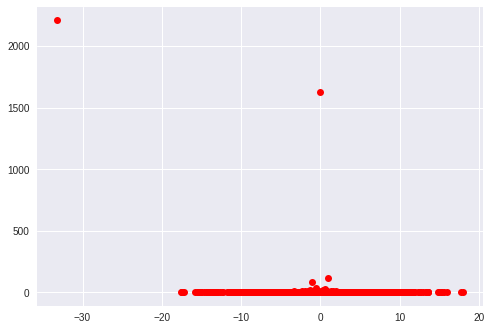



---End Line---




In [0]:
# @functools.lru_cache(maxsize=128)  # Note 2018/12/14: commented to avoid "TypeError: 'DataFrame' objects are mutable"
def check_survivor_bias(data_path, data, label):
    name_file = data_path.split('/')[-1]
    name_var = 'data_' + name_file[:-4]    
    print("[Input] File Name: {}, survivor bias checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The distribution of vacancy: ")
    
    target_set = list(set(data[label]))
    biascollector_survivor_dict = {each_target: len(data[label][data[label] == each_target]) for each_target in target_set}
    biascollector_survivor_df = pd.DataFrame(data=biascollector_survivor_dict, index=[0])
    biascollector_survivor_df.to_csv("./model/collector/bias_survivor_collector.csv", index=False)
    pprint.pprint(biascollector_survivor_df)    
    plt.plot(target_set, list(biascollector_survivor_dict.values()), 'ro', linewidth=2)
    plt.show()
    # sns.countplot(x='target', data=data_train);
    print("\n")
    print("---End Line---")
    print("\n")

    
check_survivor_bias(data_train_path, data_train, 'target')
# check_survivor_bias(data_test_path, data_test, '')

#### check time-related

In [0]:
# References: 
# jianshu.com/p/4130bac8ebe
# jianshu.com/p/9066b9e0c7af

data_train.rolling?

In [0]:
data_train_copy = copy.copy(data_train)
data_train_dates = list(set(data_train_copy['first_active_month']))
data_train_copy_slicedBydate = pd.DataFrame(data=[data_train_copy[data_train_copy['first_active_month'] == each_date].iloc[0, :] for each_date in data_train_dates], columns=data_train_copy.columns)
data_train_copy_slicedBydate.set_index(pd.to_datetime(data_train_copy_slicedBydate['first_active_month']), inplace=True)
data_train_copy_slicedBydate = data_train_copy_slicedBydate.sort_index()

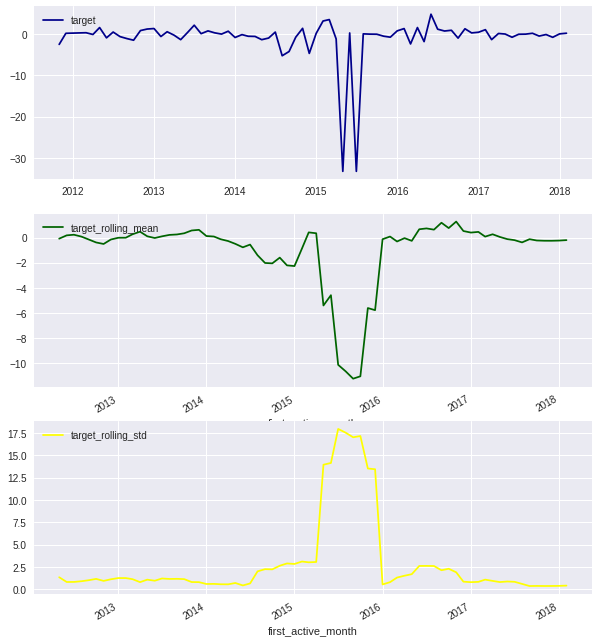

In [0]:
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(311) 
plt.plot_date(x=data_train_copy_slicedBydate.index, y=data_train_copy_slicedBydate['target'], xdate=True, marker=None, linestyle='solid', color='darkblue', label='target');
plt.legend(loc='upper left');
ax2 = fig2.add_subplot(312) 
data_train_copy_slicedBydate['target'].rolling(6).mean().plot(color='darkgreen', label='target_rolling_mean');
plt.legend(loc='upper left');
ax3 = fig2.add_subplot(313) 
data_train_copy_slicedBydate['target'].rolling(6).std().plot(color='yellow', label='target_rolling_std');
plt.legend(loc='upper left');
# data_train_copy_slicedBydate_resampled = data_train_copy_slicedBydate.resample('W-MON')  # 数据太多时的降频处理, TODO 2018/12/17: ModuleNotFoundError: No module named 'pandas.core.groupby.groupby'; 'pandas.core.groupby' is not a package
# data_train_copy_slicedBydate_resampled.plot(color='darkred')

In [0]:
LABELS = ['adf statistics', 'p value', 'used lag', 'NUmber of oberservation']


# @functools.lru_cache(maxsize=128)
def check_adfuller(data):
    results = adfuller(x=data, maxlag=12)
    for label, result in zip(LABELS, results):
        print(label + ': ' + str(result))
    if results[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, accept the null hypothesis")
        print("Data has unit root and is non-stationary")    

In [0]:
check_adfuller(data_train_copy_slicedBydate['target'])

adf statistics: -4.327545497552187
p value: 0.00039787318845015395
used lag: 3
NUmber of oberservation: 71
Strong evidence against the null hypothesis, reject the null hypothesis
Data has no unit root and is stationary


[Input] Data: first derivative of 'target', visualization for VARIABLE "data_train_copy_slicedBydate['diff1']"
[Output] visualization of vacancy numbers
1


[Output] visualization of curve trend


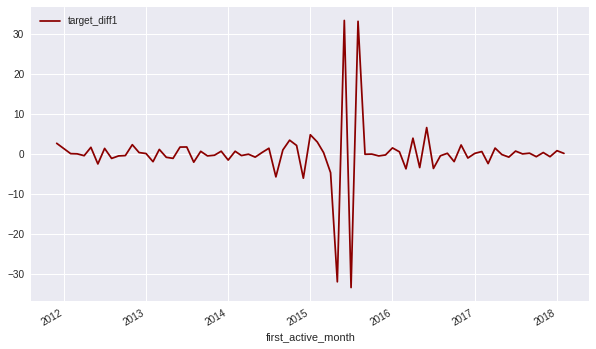



---End Line---


[Input] Data Part: second derivative of 'target', visualization for VARIABLE "data_train_copy_slicedBydate['diff2']"
[Output] visualization of vacancy numbers
2


[Output] visualization of curve trend


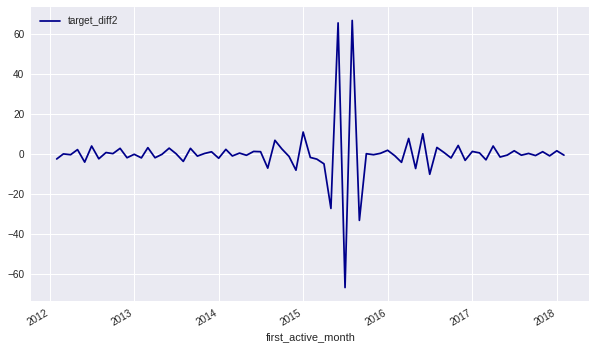



---End Line---




In [0]:
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
print("[Input] Data: {}, visualization for VARIABLE \"{}\"".format('first derivative of \'target\'', 'data_train_copy_slicedBydate[\'diff1\']'))
data_train_copy_slicedBydate['diff1'] = data_train_copy_slicedBydate['target'].diff(1)  # Note 2018/12/13: if needed, use '.dropna()''
# pprint.pprint(data_train_copy_slicedBydate['diff1'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy_slicedBydate['diff1'].isnull().sum())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate['diff1'].plot(color='darkred', label='target_diff1', ax=ax1)
plt.legend(loc='upper left')
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate['diff1'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
print("[Input] Data Part: {}, visualization for VARIABLE \"{}\"".format('second derivative of \'target\'', 'data_train_copy_slicedBydate[\'diff2\']'))
data_train_copy_slicedBydate['diff2'] = data_train_copy_slicedBydate['diff1'].diff(1)
# pprint.pprint(data_train_copy_slicedBydate['diff2'])
print("[Output] visualization of vacancy numbers")
pprint.pprint(data_train_copy_slicedBydate['diff2'].isnull().sum())
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate['diff2'].plot(color='darkblue', label='target_diff2', ax=ax2)
plt.legend(loc='upper left')
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate['diff2'])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: ddata_train_copy_slicedBydate['diff1'], determine parameters 'p, d, q' for financial sequence model fetched from it
[Output] visualization of acf curve


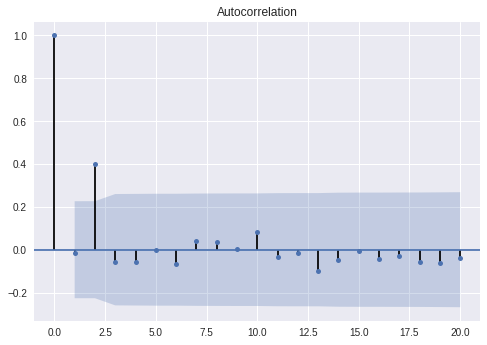



[Output] visualization of pacf curve


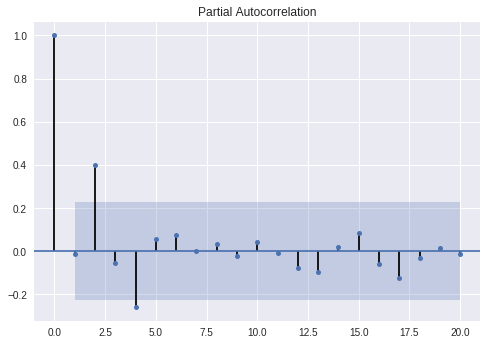

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):




---End Line---


[Input] Variable: result_arima, visualization of fitting results for financial sequence model 'ARIMA'
[Output] visualization of summary
                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:                   74
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -232.807
Method:                       css-mle   S.D. of innovations              5.598
Date:                Wed, 19 Dec 2018   AIC                            473.615
Time:                        09:17:37   BIC                            482.831
Sample:                    12-01-2011   HQIC                           477.291
                         - 02-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0165      0.328      0.050

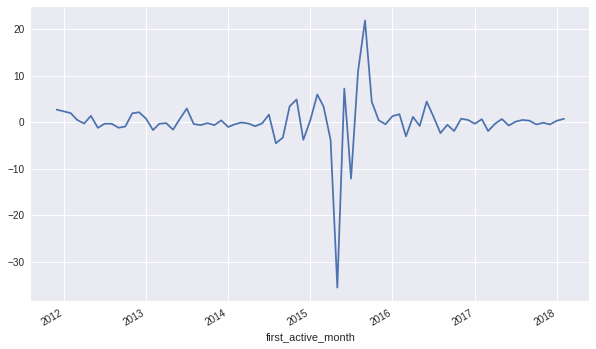

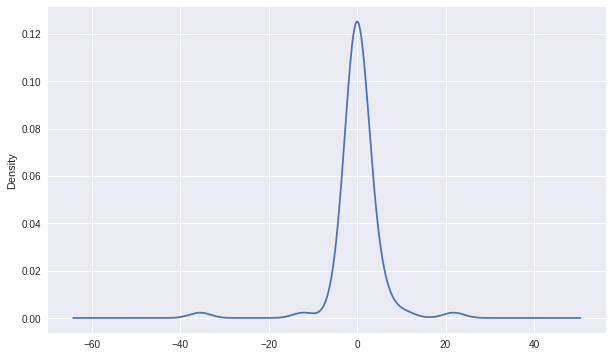



---End Line---




In [0]:
print("[Input] Variable: {}, determine parameters \'p, q\' for financial sequence model fetched from it".format('ddata_train_copy_slicedBydate[\'diff1\']'))
print("[Output] visualization of acf curve")
acf = plot_acf(data_train_copy_slicedBydate['target'], lags=20)
plt.show()
print("\n")
print("[Output] visualization of pacf curve")
pacf = plot_pacf(data_train_copy_slicedBydate['target'], lags=20)
plt.show()
model_arima = ARIMA(data_train_copy_slicedBydate['target'], order=(1, 1, 1), freq='W-MON')   # TODO 2018/12/19: check the right descriptions of choosing p and q from acf and pacf plotting 
result_arima = model_arima.fit()
print("\n")
print("---End Line---")
print("\n")

print("[Input] Variable: {}, visualization of fitting results for financial sequence model \'ARIMA\'".format('result_arima'))
print("[Output] visualization of summary")
print(result_arima.summary())
print("\n")
print("[Output] visualization of residual trend and distribution")
result_arima.resid.dropna(axis=0, inplace=True)
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
result_arima.resid.plot(ax=ax1)
plt.show()
fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
result_arima.resid.plot(ax=ax2, kind='kde')
plt.show()
print("\n")
print("---End Line---")
print("\n")

In [0]:
result_arima

In [0]:
data_train_copy_slicedBydate

In [0]:
print("[Input] Variable: {}, visualization of prediction results for financial sequence model \'ARIMA\'".format('result_arima'))
data_train_copy_slicedBydate['target_pred'] = result_arima.predict(start='2011-12-01', end='2018-02-01', typ='levels')
print("[Output] visualization of prediction curve compared with original curve")
data_train_copy_slicedBydate[['target', 'target_pred']].plot()
plt.show()
# pd.data_range(start='2018-12-1', end='2019-12-1', periods=12, freq='MS')
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: result_arima, visualization of prediction results for financial sequence model 'ARIMA'


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: ignored

### divide data category

In [0]:
data_train.columns

Index(['first_active_month', 'card_id', 'feature_1', 'feature_2', 'feature_3',
       'target'],
      dtype='object')

In [0]:
data_info[0]

,0,1
0,train.csv,NaN
1,NaN,NaN
2,Columns,Description
3,card_id,Unique card identifier
4,first_active_month,"'YYYY-MM', month of first purchase"
5,feature_1,Anonymized card categorical feature
6,feature_2,Anonymized card categorical feature
7,feature_3,Anonymized card categorical feature
8,target,Loyalty numerical score calculated 2 months af...


In [0]:
data_info[1]

,0,1
0,historical_transactions.csv,NaN
1,NaN,NaN
2,Columns,Description
3,card_id,Card identifier
4,month_lag,month lag to reference date
5,purchase_date,Purchase date
6,authorized_flag,"Y' if approved, 'N' if denied"
7,category_3,anonymized category
8,installments,number of installments of purchase
9,category_1,anonymized category


In [0]:
data_info[2]

,0,1
0,new_merchant_period.csv,NaN
1,NaN,NaN
2,Columns,Description
3,card_id,Card identifier
4,month_lag,month lag to reference date
5,purchase_date,Purchase date
6,authorized_flag,"Y' if approved, 'N' if denied"
7,category_3,anonymized category
8,installments,number of installments of purchase
9,category_1,anonymized category


In [0]:
data_info[3]

,0,1
0,merchants.csv,NaN
1,NaN,NaN
2,Columns,Description
3,merchant_id,Unique merchant identifier
4,merchant_group_id,Merchant group (anonymized )
5,merchant_category_id,Unique identifier for merchant category (anony...
6,subsector_id,Merchant category group (anonymized )
7,numerical_1,anonymized measure
8,numerical_2,anonymized measure
9,category_1,anonymized category


In [0]:
# Note 2018/12/20: assume all data in one column share the same type and the first one is not vacancy

# @functools.lru_cache(maxsize=128)  # TypeError: 'DataFrame' objects are mutable, thus they cannot be hashed
def collect_datatype(data):
    return {each_column: str(type(data[each_column][0])) for each_column in data.columns}

In [0]:
feats_all = list(set(list(data_historical_transactions.columns) + list(data_new_merchant_transactions.columns) + list(data_merchants.columns) + list(data_train.columns)))
feats_all

['city_id',
 'numerical_2',
 'installments',
 'month_lag',
 'category_2',
 'avg_purchases_lag3',
 'purchase_amount',
 'active_months_lag6',
 'avg_sales_lag6',
 'most_recent_purchases_range',
 'category_1',
 'subsector_id',
 'first_active_month',
 'category_3',
 'feature_1',
 'authorized_flag',
 'avg_purchases_lag6',
 'most_recent_sales_range',
 'active_months_lag3',
 'feature_3',
 'purchase_date',
 'avg_sales_lag3',
 'category_4',
 'merchant_id',
 'merchant_group_id',
 'avg_purchases_lag12',
 'card_id',
 'numerical_1',
 'avg_sales_lag12',
 'target',
 'merchant_category_id',
 'feature_2',
 'active_months_lag12',
 'state_id']

In [0]:
data_types_dict = {"historical_transactions_type": collect_datatype(data_historical_transactions), "new_merchant_transactions_type": collect_datatype(data_new_merchant_transactions), "merchants_type": collect_datatype(data_merchants), "trainOrtest_type": collect_datatype(data_train)}


In [0]:
data_info_train["trainOrtest_type"][trainOrtest_type_series.index] = trainOrtest_type_series.values

In [0]:
trainOrtest_type_series = pd.Series(data_types_dict["trainOrtest_type"])
data_info_train = copy.copy(data_info[0])
data_info_train["trainOrtest_type"] = [np.nan]*(len(data_info_train))
data_info_train.set_index(data_info[0][0], inplace=True)
data_info_train[trainOrtest_type_series.index] = trainOrtest_type_series.values

In [0]:
# TODO 2018/12/20: get the feat category distribution and cross section between five csv

## last process

In [0]:
class process_last(self):
    def __init__(self):
        allocate room for the variable returned by class process_mid_c
        
    def apply_scaler(self):
        use different scalers provided by sklearn with consideration of model feed
        return dataframe xxx_filled_scaled after scaling
    
    def select_feat(self):
        use algorithms like RF(SL), Kmeans(UL) or functions from sklearn
        return dataframe xxx_filled_scaled_selected after selection

# Test Parts

In [0]:
ax2 = fig.add_subplot(122)
ax2.set_title("feat %s from high vacancy data" %feat)
sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);

In [0]:
import gc
gc.collect()
sys._clear_type_cache()

In [0]:
data_stock = ts.get_hist_data('600519')
data_stock.isna().sum()
# data_stock.index

In [0]:
print(data_stock.columns, type(data_stock))

In [0]:
mean_dict, std_dict = {'feat_low_vacancy':[], 'feat_high_vacancy':[]}, {'feat_low_vacancy':[], 'feat_high_vacancy':[]}
sns.set(style="darkgrid")
def compare_dis(data_low_vacancy, data_high_vacancy, feat_low_vacancy_si, feat_high_vacancy_si, ind):
    fig = plt.figure(num=ind, figsize=(10, 15))
    ax1 = fig.add_subplot(211)
    ax1.set_title("feat %s from low vacancy data" %feat_low_vacancy_si)
    mean_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().mean())
    std_dict['feat_low_vacancy'].append(data_low_vacancy[feat_low_vacancy_si].dropna().std())
    sns.countplot(x=feat_low_vacancy_si, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(212)
    ax2.set_title("feat %s from high vacancy data" %feat_high_vacancy_si)
    mean_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().mean())
    std_dict['feat_high_vacancy'].append(data_high_vacancy[feat_high_vacancy_si].dropna().std())
    sns.countplot(x=feat_high_vacancy_si, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);
    
num = 5
feats_low_selected = random.sample(list(azdias_low.columns), num)
feats_high_selected = random.sample(list(azdias_high.columns), num)
for indent in range(num):
    compare_dis(azdias_low, azdias_high, feats_low_selected[indent], feats_high_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)